In [1]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL = 'random search'
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
ALGORITHM_DETAIL += ' 202201109[input64, norm, dense64^6, dense1]'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

debug_mode = False
quick_mode = False
quick_mode = True

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def create_model():
    if True:
        normalizer = tf.keras.layers.Normalization(axis=-1)
        model = Sequential()
        model.add(Dense(64, input_shape=(len(X_train[0]),), activation='relu'))
        model.add(normalizer)
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    else:
        normalizer = tf.keras.layers.Normalization(axis=-1)

        model = Sequential()
        model.add(normalizer)
        model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(5, activation='relu'))
        model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model


selected_model = model = KerasRegressor(model=create_model, verbose=0)




2022-11-09 22:41:24.459469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB and not IN_CLOUD:
    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221107 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')
else:
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', 'zfunctions'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results


In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [6]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [7]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [8]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [9]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [10]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [12]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [13]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [14]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [15]:
starter_pipe = make_modelling_pipeline(selected_model, DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(model=<function create_model at 0x7f0935f1b0d0>, verbose=0))])

In [16]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'model': <function __main__.create_model()>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1}

In [18]:
% timeit starter_pipe.fit(X_train, y_train)

4.79 s ± 709 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
from sklearn.model_selection import GridSearchCV

options_block = {
    'epochs': [100],
    #'optimizer' : ['rmsprop'],
    'batch_size': [100],
    #'verbosity': 1
}
options_block = {
    'epochs': [100, 500],
    #'optimizer' : ['rmsprop'],
    'batch_size': [1000, 100],

    #'verbosity': 1
}
options_block = {
    'initializer': ['normal', 'uniform'],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['mse', 'mae'],
    'batch_size': [32, 64],
    'epochs': [5, 10],
}

# options_block = {
#     #'initializer': ['normal', 'uniform'],
#     #'activation': ['relu', 'sigmoid'],
#     'optimizer': ['adam', 'rmsprop'],
#     'loss': ['mse', 'mae'],
#     'batch_size': [32, 64, 100, 1000, 10000],
#     'epochs': [5, 10, 100, 1000, 10000],
# }

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

param_options, OVERRIDE_CV, OVERRIDE_N_ITER

if False:
    def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
        model = Sequential()
        model.add(Dense(units=8, input_dim=7, kernel_initializer=initializer, activation=activation))
        model.add(Dense(units=6, kernel_initializer=initializer, activation=activation))
        model.add(Dense(1, kernel_initializer=initializer))
        model.compile(loss=loss, optimizer=optimizer)
        print(model)

        return model


    param_grid = {
        #'initializer': ['normal', 'uniform'],
        #'activation': ['relu', 'sigmoid'],
        'optimizer': ['adam', 'rmsprop'],
        'loss': ['mse', 'mae'],
        'batch_size': [32, 64],
        'epochs': [5, 10],
    }
elif False:
    def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
        model = Sequential()
        model.add(Dense(units=8, input_dim=7, kernel_initializer=initializer, activation=activation))
        model.add(Dense(units=6, kernel_initializer=initializer, activation=activation))
        model.add(Dense(1, kernel_initializer=initializer))
        model.compile(loss=loss, optimizer=optimizer)
        print(model)

        return model


    param_grid = {
        'initializer': ['normal', 'uniform'],
        'activation': ['relu', 'sigmoid'],
        'optimizer': ['adam', 'rmsprop'],
        'loss': ['mse', 'mae'],
        'batch_size': [32, 64],
        'epochs': [5, 10],
    }
else:
    #def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
    def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
        model = Sequential()
        #model.add(Dense(units=8, input_dim=7, kernel_initializer=initializer, activation=activation))
        model.add(Dense(units=8, input_dim=11, kernel_initializer=initializer, activation=activation))
        model.add(Dense(units=6, kernel_initializer=initializer, activation=activation))
        model.add(Dense(1, kernel_initializer=initializer))
        model.compile(loss=loss, optimizer=optimizer)
        print(model)

        return model


    param_grid = {
        #'initializer': ['normal', 'uniform'],
        #'activation': ['relu', 'sigmoid'],
        'model__initializer': ['normal', 'uniform'],
        'model__activation': ['relu'],
        'optimizer': ['adam', 'rmsprop'],
        'loss': ['mse'], #, 'mae'],
        'batch_size': [32, 64, 100, 1000],
        'epochs': [5, 10, 100, 500],
    }

if False:
    grid_search = GridSearchCV(
        estimator=KerasRegressor(make_regression_ann, verbose=0),
        param_grid=param_grid,
        scoring='neg_mean_absolute_percentage_error',
        cv=3,
    )
else:
    grid_search = RandomizedSearchCV(
        estimator=KerasRegressor(make_regression_ann, verbose=0),
        param_distributions=param_grid,
        scoring='neg_mean_absolute_percentage_error',
        cv=2, # 3,
        error_score='raise',
        n_iter=5 # 1, #3
    )

#X, y = make_regression(n_features=7, n_samples=100, random_state=42)

grid_search.fit(X_train, y_train, verbose=1)

grid_search.best_params_

Epoch 1/100
20/20 [==============================] - 0s 2ms/step - loss: 192444071936.0000
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 192444006400.0000
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 192443891712.0000
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 192443645952.0000
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 192443187200.0000
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 192442286080.0000
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 192440745984.0000
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 192438370304.0000
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 192435011584.0000
Epoch 10/100
20/20 [==============================] - 0s 3ms/step - loss: 192430456832.0000
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 192424509440.00

{'optimizer': 'adam',
 'model__initializer': 'uniform',
 'model__activation': 'relu',
 'loss': 'mse',
 'epochs': 10,
 'batch_size': 32}

In [61]:
grid_search.best_params_

{'optimizer': 'adam',
 'model__initializer': 'uniform',
 'model__activation': 'relu',
 'loss': 'mse',
 'epochs': 10,
 'batch_size': 32}

In [62]:
if False:
    gs = RandomizedSearchCV(starter_pipe, param_options, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                            return_train_score=True, n_iter=n_iter, error_score='raise'),

    cross_validation_result, average_cross_validation_fit_time, best_estimator_fit_time, total_fits = fit_model_with_cross_validation(
        gs, X_train, y_train, fits=cv * n_iter)
else:
    cross_validation_result = grid_search

In [63]:
best_estimator_pipe = cross_validation_result.best_estimator_

if debug_mode:
    cross_validation_result.cv_results_

In [65]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_model__initializer,param_model__activation,param_loss,param_epochs,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,params2
0,3.871351,0.127905,0.729301,0.108297,rmsprop,uniform,relu,mse,5,64,"{'optimizer': 'rmsprop', 'model__initializer':...",-0.98143,-0.985127,-0.983278,0.001848,1,rmsprop/uniform/relu/mse/5/64


In [66]:
cv_results_df = pd.DataFrame(cross_validation_result.cv_results_)
cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time',
           'params']
if 'Neural' not in ALGORITHM:
    columns.insert(2, 'mean_train_score')

cv_results_df.sort_values('rank_test_score')[
    columns]

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
1,adam/uniform/relu/mse/10/32,1,-0.612939,12.459720,1.408226,"{'optimizer': 'adam', 'model__initializer': 'u..."
0,rmsprop/normal/relu/mse/100/1000,2,-0.952713,5.244411,0.174192,"{'optimizer': 'rmsprop', 'model__initializer':..."
4,rmsprop/normal/relu/mse/5/100,3,-0.985688,2.643423,0.399886,"{'optimizer': 'rmsprop', 'model__initializer':..."
2,adam/uniform/relu/mse/10/1000,4,-0.999990,1.115962,0.162739,"{'optimizer': 'adam', 'model__initializer': 'u..."
3,adam/uniform/relu/mse/5/1000,5,-0.999998,0.767376,0.143464,"{'optimizer': 'adam', 'model__initializer': 'u..."


In [67]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(cross_validation_result)

In [68]:
print('Best Index: ', cross_validation_result.best_index_)
print('Best Score: ', cross_validation_result.best_score_)
print('Best Params: ', cross_validation_result.best_params_)

Best Index:  1
Best Score:  -0.6129385587577187
Best Params:  {'optimizer': 'adam', 'model__initializer': 'uniform', 'model__activation': 'relu', 'loss': 'mse', 'epochs': 10, 'batch_size': 32}


In [69]:
y_pred = best_estimator_pipe.predict(X_test)

In [70]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy -15.993856020380491
Mean Absolute Error Accuracy 425056.56702962454
Mean Squared Error Accuracy 191969490803.8201
Root Mean Squared Error 438143.23092319944


In [71]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [72]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754.0,400000.0,12.408724,399987.591276,99.996898,3.223439e+06
119328242.0,369950.0,12.408724,369937.591276,99.996646,2.981270e+06
125716790.0,350000.0,12.408724,349987.591276,99.996455,2.820496e+06
122440040.0,549000.0,12.408724,548987.591276,99.997740,4.424207e+06
120508103.0,495000.0,12.408724,494987.591276,99.997493,3.989029e+06
...,...,...,...,...,...
68620869.0,475000.0,12.408724,474987.591276,99.997388,3.827852e+06
85735665.0,575000.0,12.408724,574987.591276,99.997842,4.633737e+06
125706338.0,400000.0,12.408724,399987.591276,99.996898,3.223439e+06


In [176]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [177]:
score = best_estimator_pipe.score(X_test, y_test)
score

0.6469541216784913

In [178]:
r2_score(y_test, y_pred)

0.6469541216784913

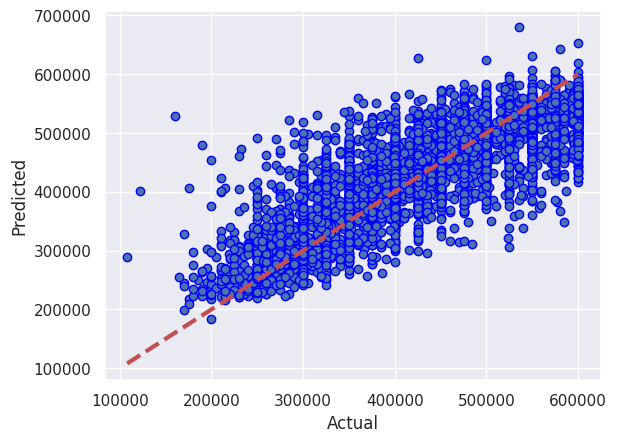

In [179]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [180]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

for h in range(-1, best_model_count, 1):
    if h < 0:
        i = total_fits - 1
    elif h == 0:
        i = 0
    elif 10 * h > total_fits:
        continue
    else:
        i = 10 * h
    if debug_mode: print(h, i)

    graph_params_pipe = cv_results_df['params'][i]

    graph_params_pipe = cv_results_df.loc[cv_results_df['rank_test_score'] == 1, 'params'].values[0]

    graph_params = {}
    for key, value in graph_params_pipe.items():
        graph_params[key.replace('model__', '')] = value

    fitted_graph_model, y_pred_graph = custom_model_and_predictions(selected_model, graph_params, X_train,
                                                                    y_train, X_test)

    if h == -1:
        i = -1
    best_models[i] = fitted_graph_model
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


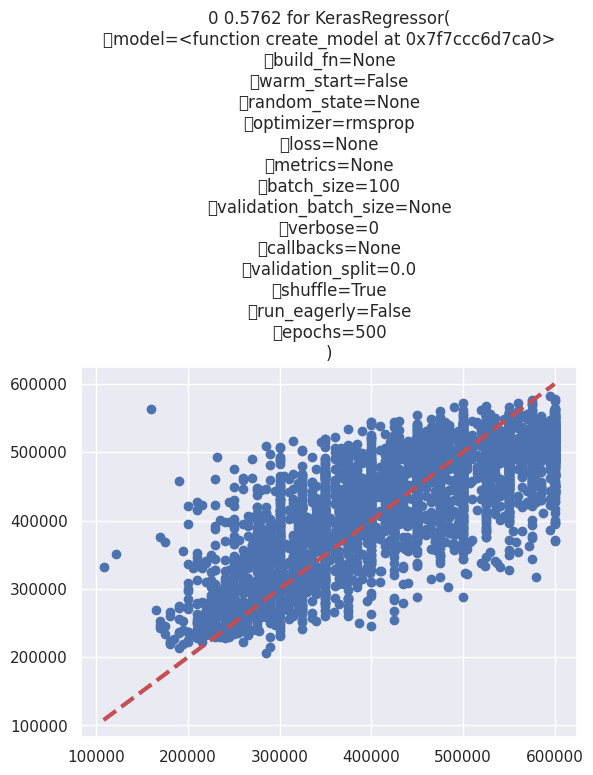

In [181]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.show()

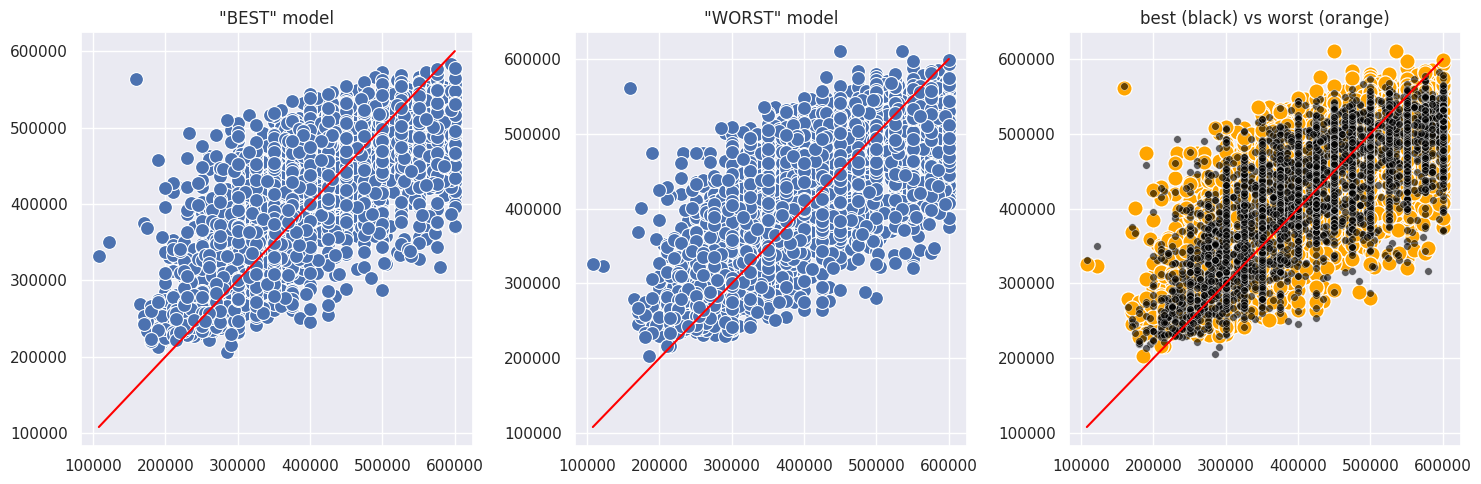

In [182]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [188]:
results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': best_estimator_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': cross_validation_result.best_params_
}

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results, key)

print(key)
results

neural network - random search 202201109[input64, norm, dense64^6, dense1] (v06)


''

In [186]:
cross_validation_result.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(batch_size=100, epochs=500, model=<function create_model at 0x7f7d1d5e9af0>, verbose=0))])

In [185]:
with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
    pickle.dump(cross_validation_result.best_estimator_, f)

PicklingError: Can't pickle <function create_model at 0x7f7d1d5e9af0>: it's not the same object as __main__.create_model

In [ ]:
feature_importances = cross_validation_result.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
          df_features.columns[indices[f] + 1])


In [ ]:
feature_importances = cross_validation_result.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])